In [23]:
# Imports

import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

In [2]:
# Create Function to calculate returns


def get_returns(stock_prices):
    stock_price_returns = stock_prices.copy()
    
    # Calculate stock returns per day
    for i in range(1,len(stock_prices)):
        stock_price_returns.iloc[i] = (stock_prices.iloc[i]-stock_prices.iloc[i-1])/stock_prices.iloc[i-1]
    
    # Exclude first day since no data for returns available
    stock_price_returns = stock_price_returns.iloc[1:,:]
    return stock_price_returns

In [3]:
# Create function to get returns difference

def get_difference(stock_prices, stock_list, weights):
    
    stock_prices.index = stock_prices.iloc[:,0]
    stock_prices = stock_prices.iloc[:,1:]
    stock_returns = get_returns(stock_prices)
    
    sum_diff=0
    # For each day of data -
    for i in range(len(stock_returns)):
        # Get returns for that day
        ret = stock_returns[stock_list].iloc[i]
        
        # Calculate total returns of stocks based on weights
        sum_ret = sum(x * y for x, y in zip(ret, weights))
        
        # Update the sum of differences per day (assuming first column is return of index)
        sum_diff = sum_diff + abs(stock_returns.iloc[i,0] - sum_ret)
        
    return sum_diff

In [4]:
# Import stocks 2019 file
st_2019 = pd.read_csv("data/stocks2019.csv")



In [5]:
# Create function to calculate ideal stocks and optimal value -

def get_ideal_stocks(st, m):
    st.index = st.iloc[:,0]
    st = st.iloc[:,1:]


    st_returns = get_returns(st.iloc[:,1:])
    st_returns_NDX = get_returns(st)
    # Get correlation matrix
    p = st_returns.corr()




    # No. of variables -
    n_ind_stocks = len(p.columns)
    x_no = len(p.columns)*len(p.columns)
    y_no = len(p.columns)
    no_of_var = x_no + y_no



    # Total constraints = sum of all Xij for each j equals 1 (Total no. stocks in index) 
    #                     + Xij for each j less than equal to Yj (Total no. stocks in index^2)
    #                     + Sum of all Y equal to m (1)
    no_of_constraints = n_ind_stocks + x_no + 1





    # Get objective equation -
    obj=[]
    for i in range(len(p)):
        obj.extend(p.iloc[:,i])

    # Add y no. of zeroes at the end to account for all y variables
    zeroes = [0]*y_no
    obj.extend(zeroes)
    obj = np.array(obj)

    # Constraints

    # Initialize constraints
    A = np.zeros((no_of_constraints,no_of_var))


    for i in range(0,n_ind_stocks):
        start = i*n_ind_stocks
        stop = i*n_ind_stocks + n_ind_stocks
        A[i,start:stop] = 1
    

    for i in range(0,x_no):
    
        # For Xs
        A[n_ind_stocks+i,i] = 1
        # For Y
        y_posn = i%n_ind_stocks
        A[n_ind_stocks+i,x_no+y_posn] = -1
    
    # Sum of all Ys should be m
    A[n_ind_stocks+x_no,x_no:] = 1


    # Sense

    # Equality for sum of Xs for each stock = 1
    sense = ['=']*n_ind_stocks

    # All Xij should be lesser than Yj
    t = ['<']*x_no
    sense.extend(t)

    # Equality for sum of Ys = m
    sense.extend(['='])

    sense = np.array(sense)



    # Limits

    # Sum of Xs for each stock = 1
    b = [1]*n_ind_stocks


    # All Xij should be lesser than Yj
    t = [0]*x_no
    b.extend(t)

    # Sum of Ys = m
    b.extend([m])

    b = np.array(b)
    
    
    ############## GUROBI SOLVER#############
    ojModel = gp.Model() # initialize an empty model

    ojModX = ojModel.addMVar(len(obj), vtype=['B']*len(obj)) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
    ojModel.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

    ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!
    ojModel.Params.TimeLimit = 3600

    ojModel.optimize() # solve the LP
    val = ojModel.objVal # optimal level
    
    # What are my ideal stocks?

    mask = list(pd.Series(ojModX.x[-y_no:]).replace([0,1],[False,True]))
    stocks = list(p.columns[mask])
    
    return p, val, stocks

In [6]:
p, val, stocks_2019 = get_ideal_stocks(st_2019, m=5)



Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-19


C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\2220668647.py:1: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  p, val, stocks_2019 = get_ideal_stocks(st_2019, m=5)


## Correlation Matrix -

In [7]:
p

,ATVI,ADBE,AMD,ALXN,ALGN,GOOGL,GOOG,AMZN,AMGN,ADI,...,TCOM,ULTA,VRSN,VRSK,VRTX,WBA,WDAY,WDC,XEL,XLNX
ATVI,1.000000,0.399939,0.365376,0.223162,0.216280,0.433097,0.426777,0.467076,0.203956,0.329355,...,0.322906,0.128241,0.464850,0.316549,0.259679,0.218149,0.311659,0.303077,0.043389,0.249667
ADBE,0.399939,1.000000,0.452848,0.368928,0.363370,0.552125,0.540404,0.598237,0.291978,0.473815,...,0.360392,0.201151,0.711339,0.541243,0.402171,0.228106,0.650430,0.361516,0.207403,0.289497
AMD,0.365376,0.452848,1.000000,0.301831,0.344252,0.418861,0.417254,0.549302,0.151452,0.503733,...,0.332776,0.210623,0.498342,0.330900,0.272983,0.281950,0.407626,0.438892,0.017283,0.478010
ALXN,0.223162,0.368928,0.301831,1.000000,0.332433,0.315993,0.307698,0.363170,0.342022,0.317040,...,0.257143,0.408936,0.350581,0.191489,0.522423,0.192720,0.416396,0.289908,0.047947,0.200356
ALGN,0.216280,0.363370,0.344252,0.332433,1.000000,0.248747,0.250316,0.399281,0.264599,0.328280,...,0.175957,0.128559,0.360886,0.251855,0.334978,0.219595,0.308968,0.284407,0.088059,0.253934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WBA,0.218149,0.228106,0.281950,0.192720,0.219595,0.232900,0.230603,0.288168,0.194490,0.347861,...,0.257049,0.145330,0.195475,0.126118,0.214585,1.000000,0.211641,0.296309,-0.130798,0.276643
WDAY,0.311659,0.650430,0.407626,0.416396,0.308968,0.379493,0.371826,0.424748,0.211712,0.351734,...,0.235045,0.269545,0.569672,0.401476,0.376047,0.211641,1.000000,0.315699,0.209240,0.254117
WDC,0.303077,0.361516,0.438892,0.289908,0.284407,0.328619,0.322110,0.419620,0.172623,0.602935,...,0.377215,0.126463,0.331916,0.308558,0.314773,0.296309,0.315699,1.000000,-0.076115,0.516958
XEL,0.043389,0.207403,0.017283,0.047947,0.088059,0.059930,0.052570,0.076724,0.137857,-0.047259,...,-0.172752,0.074686,0.280371,0.407770,0.191667,-0.130798,0.209240,-0.076115,1.000000,-0.117552


# Let's find out which stocks will be selected in our fund -

In [8]:
stocks_2019

['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

## Ideal stocks are - ['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

# Let's calculate the optimal weights

In [9]:

def get_weights(st, m, stocks):

    st.index = st.iloc[:,0]
    st = st.iloc[:,1:]


    st_returns = get_returns(st.iloc[:,1:])
    st_returns_NDX = get_returns(st)

    # Let d_i = difference between q_i (index return) and sum of weight_n*rteurn of stock n_i at time = i
    # Our objective is to reduce the sum of these deifferences

    no_weights = m
    no_diff = len(st_returns)

    # No of variables = Total differences for each period (total time periods) + Weights (m)

    no_of_var = no_diff + no_weights


    # No. of constraints = Total differences for each period (total time periods)*2 + Sum of all weights = 1 (1 constraint)
    # We multiply by 2 because for each time period in order to convert the modulus condition into linear space, 
    # we need to create 2 linear conditions
    no_of_constraints = no_diff*2+1


    obj = [1]*no_diff
    obj.extend([0]*no_weights)
    obj = np.array(obj)


    # Initialize constraints
    A = np.zeros((no_of_constraints, no_of_var))


    b = []
    sense = []

    for i in range(0,no_diff*2,2):
        A[i,i//2] = 1
        A[i,no_diff:] = list(st_returns[stocks].iloc[i//2])
        sense.append('>')
        b.append(st_returns_NDX.iloc[i//2][0])
    
    
        A[i+1,i//2] = 1
        A[i+1,no_diff:] = list(st_returns[stocks].iloc[i//2]*-1)
        sense.append('>')
        b.append(st_returns_NDX.iloc[i//2][0]*-1)
    

    # Sum of all weights should be 1

    A[no_diff*2,no_diff:] = 1
    sense.append('=')
    b.append(1)

    ############### GUROBI SOLVER################
    ojModel = gp.Model() # initialize an empty model

    ojModX = ojModel.addMVar(len(obj)) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
    ojModel.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE) # add the objective to the model...we'll talk about the None and the 0

    ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!
    ojModel.Params.TimeLimit = 3600

    ojModel.optimize() # solve the LP
    stock_diff = ojModel.objVal # optimal sum of differences in returns
    
    
    # What are the optimal weights?
    weights = list(ojModX.x[-m:])
    
    return weights, stock_diff

# Let's define the function that will later be used in Q4 to solve the MIP

In [10]:
def get_alloc_weights(st, m, time_limit=3600):

    st.index = st.iloc[:,0]
    st = st.iloc[:,1:]


    st_returns = get_returns(st.iloc[:,1:])
    st_returns_NDX = get_returns(st)

    # Let d_i = difference between q_i (index return) and sum of weight_n*rteurn of stock n_i at time = i
    # Our objective is to reduce the sum of these deifferences

    no_diff = len(st_returns)
    no_weights = len(st_returns.columns)
    no_stocks = len(st_returns.columns)
    # No of variables = Total differences for each period (total time periods) + Weights (m)

    no_of_var = no_diff + no_weights + no_stocks


    # No. of constraints = Total differences for each period (total time periods)*2 + Big-M constraints + Sum of all weights+sum of all Ys = m = 1 (1 constraint)
    # We multiply by 2 because for each time period in order to convert the modulus condition into linear space, 
    # we need to create 2 linear conditions
    no_of_constraints = no_diff*2+no_stocks+1+1


    obj = [1]*no_diff
    obj.extend([0]*(no_weights+no_stocks))
    obj = np.array(obj)


    # Initialize constraints
    A = np.zeros((no_of_constraints, no_of_var))


    b = []
    sense = []

    for i in range(0,no_diff*2,2):
        A[i,i//2] = 1
        A[i,no_diff:no_diff+no_weights] = list(st_returns.iloc[i//2])
        sense.append('>')
        b.append(st_returns_NDX.iloc[i//2][0])
    
    
        A[i+1,i//2] = 1
        A[i+1,no_diff:no_diff+no_weights] = list(st_returns.iloc[i//2]*-1)
        sense.append('>')
        b.append(st_returns_NDX.iloc[i//2][0]*-1)
        
    # Big M constraints
    # Some value slightly greater than 1 because value of weight cannot exceed 1
    M = 1.1
    
    for i in range(no_weights):
        A[no_diff*2+i,[no_diff+i,no_diff+no_weights+i]] = [1,-M]
        sense.append('<')
        b.append(0)
    

    # Sum of all weights should be 1

    A[no_diff*2+no_weights,no_diff:no_diff+no_weights] = 1
    sense.append('=')
    b.append(1)
    
    
    # Sum of all Ys should be m

    A[no_diff*2+no_weights+1,no_diff+no_weights:] = 1
    sense.append('=')
    b.append(m)
    
    vtype = ['C']*(no_diff+no_weights) + ['B']*no_stocks
    
    ############### GUROBI SOLVER################
    ojModel = gp.Model() # initialize an empty model

    ojModX = ojModel.addMVar(len(obj),vtype=vtype) # tell the model how many variables there are
    # must define the variables before adding constraints because variables go into the constraints
    ojModCon = ojModel.addMConstrs(A, ojModX, sense, b) # add the constraints to the model
    ojModel.setMObjective(None,obj,0,sense=gp.GRB.MINIMIZE) # add the objective to the model...we'll talk about the None and the 0

    ojModel.Params.OutputFlag = 0 # tell gurobi to shut up!!
    ojModel.Params.TimeLimit = time_limit

    ojModel.optimize() # solve the LP
    stock_diff = ojModel.objVal # optimal sum of differences in returns
    
    
    # What are my ideal stocks?

    mask = list(pd.Series(ojModX.x[-no_stocks:]).replace([0,1],[False,True]))
    stocks = list(st_returns.columns[mask])
    
    
    # What are the ideal weights?
    weights = list(ojModX.x[no_diff:no_diff+no_weights])
    
    return weights, stocks, stock_diff

In [11]:
# Get optimal weights

weights, stock_diff_2019 = get_weights(st_2019, m=5, stocks=stocks_2019)

stock_diff_2019

C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1134399133.py:3: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights, stock_diff_2019 = get_weights(st_2019, m=5, stocks=stocks_2019)


0.7891782824631451

## Tracking Error in 2019 = 0.789178

In [12]:
# What are the weights allocated to each stock?
weights_perc = list(np.round(pd.Series(weights)*100,2))
weights_perc

[4.89, 21.04, 58.04, 7.12, 8.92]

## Ideal allocations of stocks in the 5 stock fund are - [4.89%, 21.04%, 58.04%, 7.12%, 8.92%] for the stocks ['LBTYK', 'MXIM', 'MSFT', 'VRTX', 'XEL']

In [13]:
# Let's look at how well these weights track in 2020 -

st_2020 = pd.read_csv("data/stocks2020.csv")

sum_diff_2020 = get_difference(st_2020, stocks_2019, weights)

sum_diff_2020

0.8696699433741913

## Tracking Error in 2020 = 0.869669

In [14]:
# Now, let's calculate tracking error for multiple values of m (no of stocks in fund) -


def get_tracking_error(st_2019, st_2020,method=1,time_limit=3600):
    # Get final no. of m
    if len(st_2019.columns)-2<=100:
        m_max = ((len(st_2019.columns)-2)//10)*10
    else:
        m_max = 100

    tr_2019_list = pd.DataFrame(columns=['M','Tracking Error 2019'])
    tr_2020_list = pd.DataFrame(columns=['M','Tracking Error 2020'])
    tr_2019_l = []
    tr_2020_l = []
    m_list = []
    stock_list =[]
    weight_list =[]
    
    for i in range(10,m_max+1,10):
        
        m_list.append(i)
        
        if method==1:
            # First get weights and tracking error from 2019 data
            p_2019, val, stocks_2019 = get_ideal_stocks(st_2019, m=i)
            stock_list.append(stocks_2019)
            weights_2019, stock_diff_2019 = get_weights(st_2019, m=i, stocks=stocks_2019)
            weight_list.append(weights_2019)
            tr_2019_l.append(stock_diff_2019)
        else:
            weights_2019, stocks_2019, stock_diff_2019 = get_alloc_weights(st_2019, m=i, time_limit=time_limit)
            tr_2019_l.append(stock_diff_2019)
        
        # Now get tracking error of 2020 data based on 2019 weights
        
        sum_diff_2020 = get_difference(st_2020, stocks_2019, weights_2019)
        tr_2020_l.append(sum_diff_2020)
    

                     
    tr_2019_list['M'] = m_list
    tr_2019_list['Tracking Error 2019'] = tr_2019_l    
                
    tr_2020_list['M'] = m_list
    tr_2020_list['Tracking Error 2020'] = tr_2020_l
    
    return tr_2019_list, tr_2020_list, weight_list, stock_list

# Lets get the tracking by the first method, i.e first solving an IP to get stocks and then an LP to solve for weights -

C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  p_2019, val, stocks_2019 = get_ideal_stocks(st_2019, m=i)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:27: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights_2019, stock_diff_2019 = get_weights(st_2019, m=i, stocks=stocks_2019)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  p_2019, val, stocks_2019 = get_ideal_stocks(st_2019, m=i)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:27: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights_2019, stock_diff_2019 = get_weights(st_2019, m=i, stocks=stocks_2019)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:25: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  p_2019, val, stocks_2019 = get_ideal_stocks(st_2019, m=i)
C:\Us

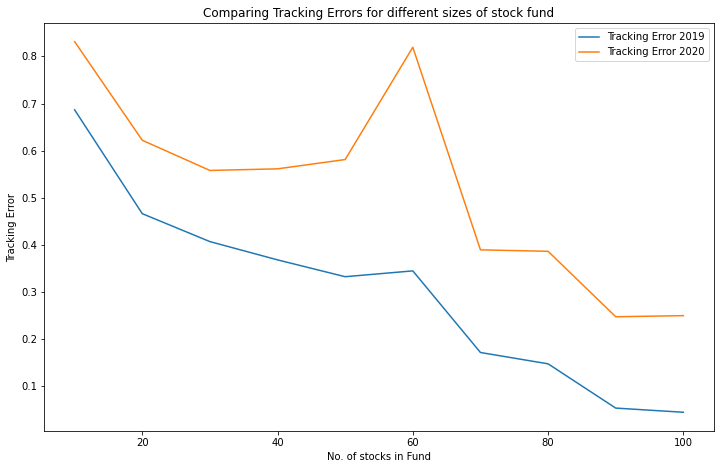

In [17]:
tr_2019_list, tr_2020_list, temp, temp_1 = get_tracking_error(st_2019, st_2020)

plt.rcParams["figure.figsize"] = (12,7.5)
plt.title("Comparing Tracking Errors for different sizes of stock fund")
plt.plot(tr_2019_list['M'], tr_2019_list['Tracking Error 2019'])
plt.plot(tr_2019_list['M'], tr_2020_list['Tracking Error 2020'])
plt.legend(['Tracking Error 2019','Tracking Error 2020'])
plt.xlabel("No. of stocks in Fund")
plt.ylabel("Tracking Error")
plt.show()


In [22]:
temp



[[0.04113108880017521,
  0.012208224438274089,
  0.03947107175624778,
  0.021508377315337442,
  0.02807146040856305,
  0.1632442397093635,
  0.48152712144237886,
  0.08980657720471816,
  0.057000247821432946,
  0.06603159110350894],
 [0.017568251619136548,
  0.015084885097906113,
  0.1835929746418432,
  0.058182667578740674,
  0.016857522030630345,
  0.007418681796449269,
  0.06713922918953467,
  0.019797441843550697,
  0.0036978412755920257,
  0.04895155474059817,
  0.02014676914673593,
  0.004656574160243992,
  0.10796195629649138,
  0.2892733668810813,
  0.0013673548488788464,
  0.043142543926188014,
  0.011028364494418246,
  0.012464064471420785,
  0.03620606457685506,
  0.03546189138370475],
 [0.031891962955075966,
  0.0344820355899443,
  0.1623007923980013,
  0.018365825627970404,
  0.016660795637392454,
  0.007328993294451869,
  0.04827448981258108,
  0.04343460059061831,
  0.007725348608527029,
  0.014689570455321682,
  0.0,
  0.013376992836734668,
  0.01132487282367763,
  0.01

# Now let's calculate the tracking error via the second method , i.e by solving the MIP

C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:31: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights_2019, stocks_2019, stock_diff_2019 = get_alloc_weights(st_2019, m=i, time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:31: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights_2019, stocks_2019, stock_diff_2019 = get_alloc_weights(st_2019, m=i, time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:31: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights_2019, stocks_2019, stock_diff_2019 = get_alloc_weights(st_2019, m=i, time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:31: DeprecationWarning: Deprecated, use Model.addMConstr() instead
  weights_2019, stocks_2019, stock_diff_2019 = get_alloc_weights(st_2019, m=i, time_limit=time_limit)
C:\Users\Mihir\AppData\Local\Temp\ipykernel_48748\1025234570.py:31: 

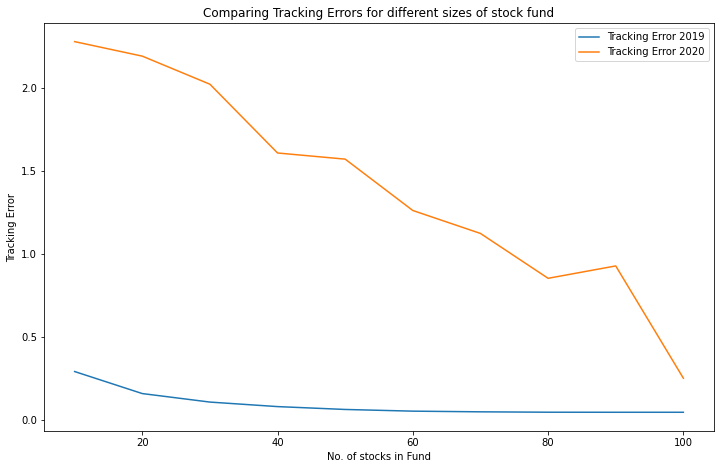

In [19]:
tr_2019_list, tr_2020_list, weight_list_2019, stock_list_2019 = get_tracking_error(st_2019, st_2020, method=2,time_limit=3600)

plt.rcParams["figure.figsize"] = (12,7.5)
plt.title("Comparing Tracking Errors for different sizes of stock fund")
plt.plot(tr_2019_list['M'], tr_2019_list['Tracking Error 2019'])
plt.plot(tr_2019_list['M'], tr_2020_list['Tracking Error 2020'])
plt.legend(['Tracking Error 2019','Tracking Error 2020'])
plt.xlabel("No. of stocks in Fund")
plt.ylabel("Tracking Error")
plt.show()

In [24]:
tr_2019_list

,M,Tracking Error 2019
0,10,0.290137
1,20,0.157501
2,30,0.106251
3,40,0.079046
4,50,0.061801
5,60,0.051634
6,70,0.047568
7,80,0.045227
8,90,0.044911
9,100,0.044911


In [37]:
df12 = pd.DataFrame(data=[25.01,11.38,19.17,28.99,15.46])

#l1 = [25.01,11.38,19.17,28.99,15.46]

#df12.append(l1)

df12 = df12.rename({0: "weights"}, axis=1)

df12 = df12.rename({0: "AMZN",1:"ADI",2:"AAPL",3:"MSFT",4:"MDLZ"})
df12.sort_values(by="weights", ascending=False, inplace=True)
df12

,weights
MSFT,28.99
AMZN,25.01
AAPL,19.17
MDLZ,15.46
ADI,11.38


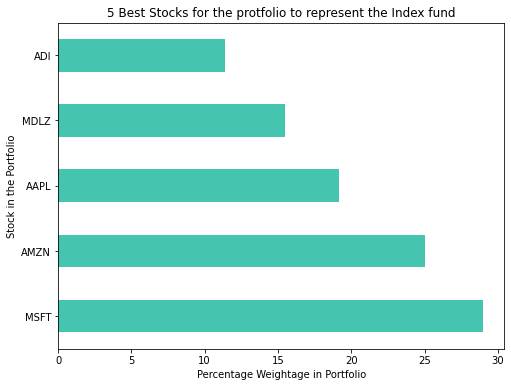

In [39]:
(df12).plot.barh(y="weights", color='#45C4B0', legend=None, figsize=(8, 6))
plt.title("5 Best Stocks for the protfolio to represent the Index fund")
plt.xlabel("Percentage Weightage in Portfolio")
plt.ylabel("Stock in the Portfolio")
plt.show()